In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/system/linux/mambaforge-3.11/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/accounts/grad/phudish_p/.local/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 64
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=5,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=5,out_channels=10,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(10*5*5,50),
            nn.ReLU(),
            nn.Linear(50,10)
        )
    
    def forward(self,x):
        x = self.layer(x)
        #print(f"Shape of x : {x.shape}")
        x = x.view(-1,10*5*5)
        x = self.fc_layer(x)
        return x 

In [7]:
def train_test_epochs(model, train_loader, test_loader, epochs, lr, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    model.to(device)
    model.eval()
    initial_test_loss = 0.0
    initial_test_correct = 0
    initial_test_total = 0
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Initial Test'):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            initial_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            initial_test_total += labels.size(0)
            initial_test_correct += (predicted == labels).sum().item()
    initial_test_loss /= len(test_loader)
    initial_test_accuracy = 100 * initial_test_correct / initial_test_total
    test_losses.append(initial_test_loss)
    test_accuracies.append(initial_test_accuracy)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}'), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader, desc=f'Epoch {epoch+1} Test'):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_loss /= len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    return np.array(train_losses), np.array(test_losses), np.array(train_accuracies), np.array(test_accuracies)

In [8]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses, test_losses, train_accuracies, test_accuracies = train_test_epochs(model, train_loader, test_loader, 10, 0.001, device)

Epoch 10 Test: 100%|██████████| 157/157 [00:01<00:00, 107.01it/s]


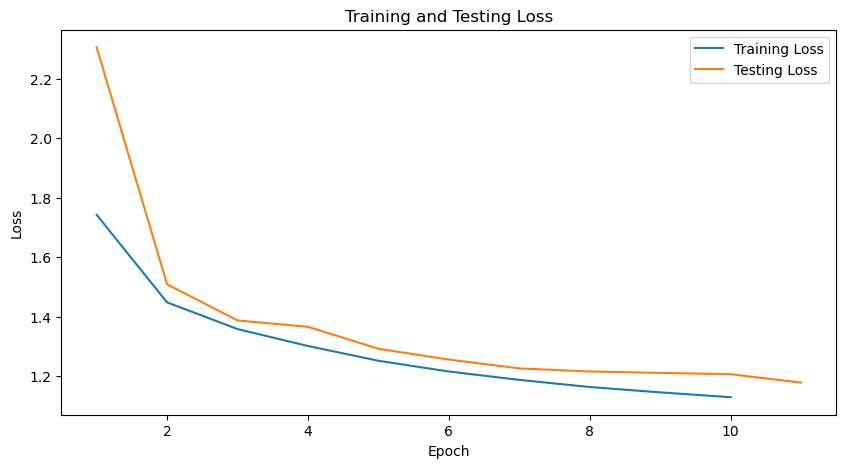

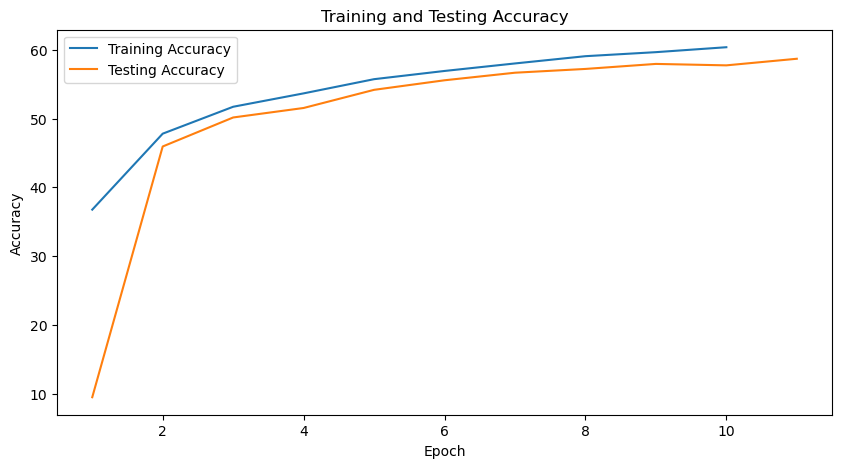

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Plotting training and testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [10]:
print(f"The best test accuracy : {torch.max(torch.from_numpy(test_accuracies))}")

The best test accuracy : 58.7


## First apply with various the hyperparameters(by changing different learning rates) and architecture (by changing the kernel size)

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=5,kernel_size=7,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=5,out_channels=10,kernel_size=7,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(10*3*3,50),
            nn.ReLU(),
            nn.Linear(50,10)
        )
    
    def forward(self,x):
        x = self.layer(x)
        #print(f"Shape of x : {x.shape}")
        x = x.view(-1,10*3*3)
        x = self.fc_layer(x)
        return x 

In [23]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses, test_losses, train_accuracies, test_accuracies = train_test_epochs(model, train_loader, test_loader, 10, 0.001, device)

Epoch 10 Test: 100%|██████████| 157/157 [00:01<00:00, 115.59it/s]


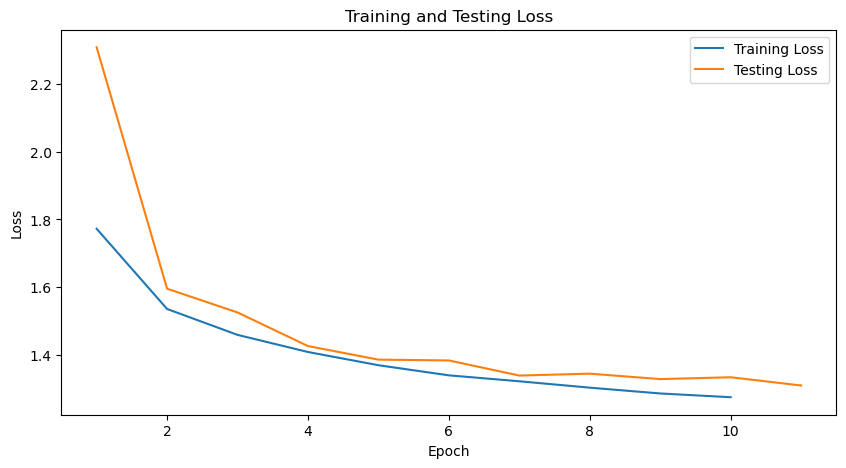

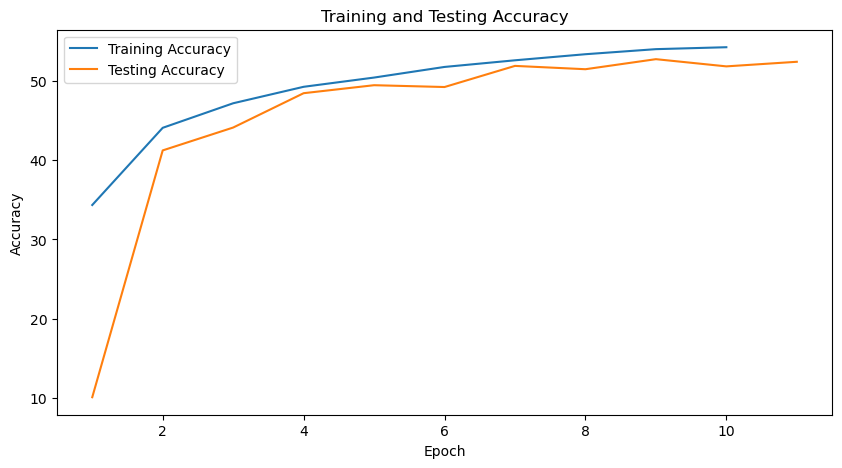

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [25]:
print(f"The best test accuracy : {torch.max(torch.from_numpy(test_accuracies))}")

The best test accuracy : 52.78


In [15]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses, test_losses, train_accuracies, test_accuracies = train_test_epochs(model, train_loader, test_loader, 10, 0.3, device)

Epoch 10 Test: 100%|██████████| 157/157 [00:01<00:00, 108.52it/s]


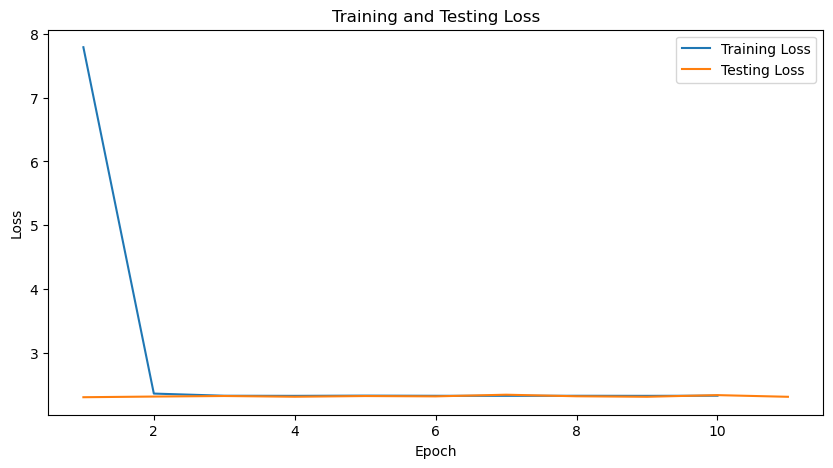

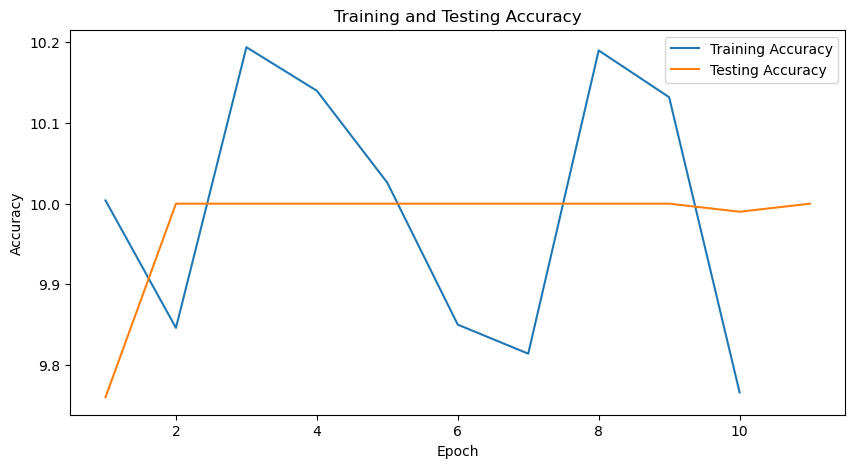

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [18]:
print(f"The best test accuracy : {torch.max(torch.from_numpy(test_accuracies))}")

The best test accuracy : 10.0


In [26]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses, test_losses, train_accuracies, test_accuracies = train_test_epochs(model, train_loader, test_loader, 10, 0.003, device)

Initial Test:  54%|█████▎    | 84/157 [00:00<00:00, 112.12it/s]

Epoch 10 Test: 100%|██████████| 157/157 [00:01<00:00, 108.04it/s]


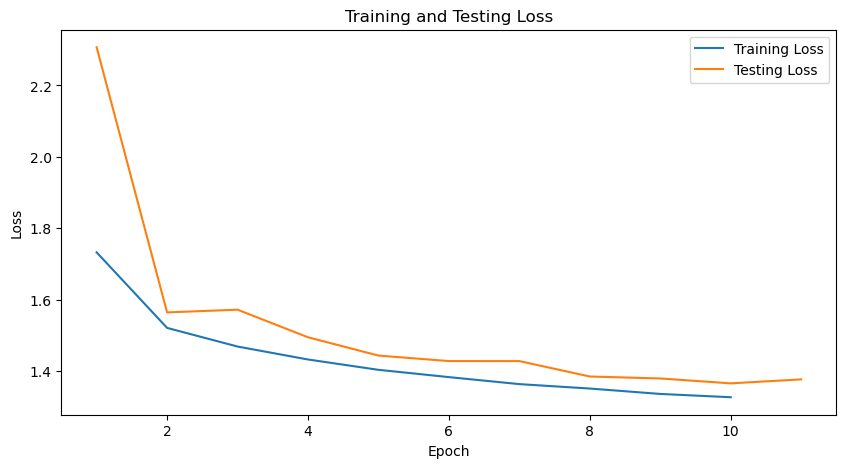

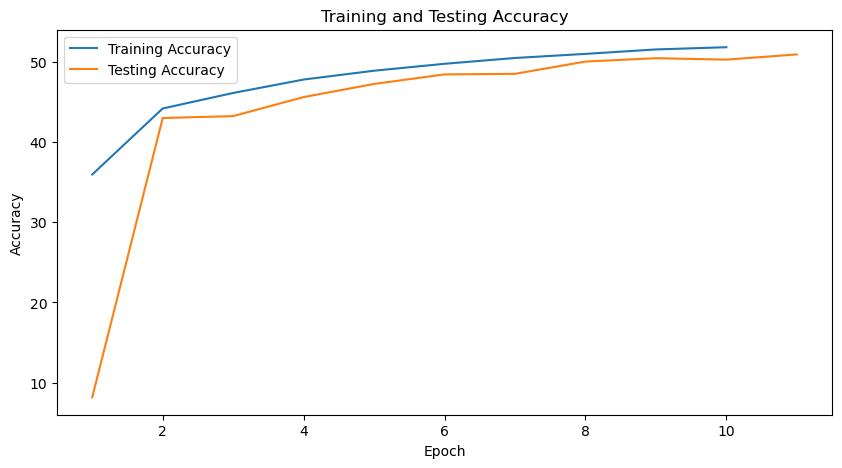

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [29]:
print(f"The best test accuracy : {torch.max(torch.from_numpy(test_accuracies))}")

The best test accuracy : 50.93


### From this we can see that when we change increase our kernel size which make each of our image become smaller the accuracy decreases. Additionally, we also see that if our learning rate is too high then our accuracy also decrease as well

## Reduce the hyperparameter search space

#### We have that the first layer (first conv2d) map image from (3,32,32) --> (5,28,28) which mean that the compression ratio is (3x32x32)/(5x28x28) = 0.784 then we applied max pool which bring down to (5,28,28) --> (5,14,14) then we have that the compression ratio is 4. Then we apply the next conv2d which map (5,14,14) --> (10,10,10) has a compression ratio of 0.98. Then we apply the next max pool which bring (10,10,10) --> (10,5,5) which has compression ratio of 4. The total compression ratio would be 0.784x4x0.98x4 = 12.29312. We also have that the MEC for our linear layer is (250+1)x50 + 10 = 12550 + 10 = 12560

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=5,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=5,out_channels=10,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(10*5*5,50),
            nn.ReLU(),
            nn.Linear(50,10)
        )
    
    def forward(self,x):
        x = self.layer(x)
        #print(f"Shape of x : {x.shape}")
        x = x.view(-1,10*5*5)
        x = self.fc_layer(x)
        return x 

In [31]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses, test_losses, train_accuracies, test_accuracies = train_test_epochs(model, train_loader, test_loader, 10, 0.001, device)

Epoch 10 Test: 100%|██████████| 157/157 [00:01<00:00, 106.02it/s]


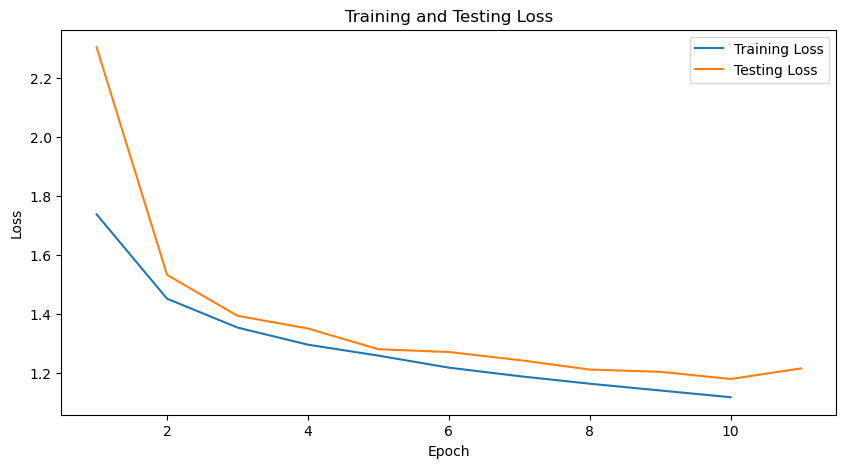

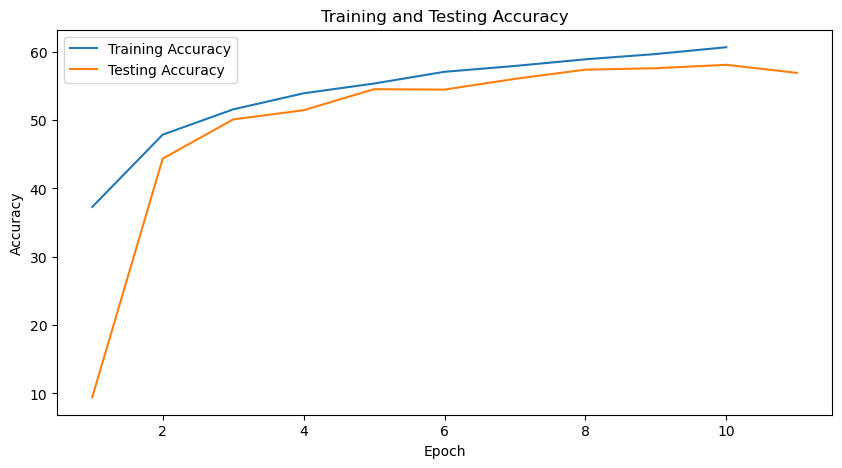

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Plotting training and testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [33]:
print(f"The best test accuracy : {torch.max(torch.from_numpy(test_accuracies))}")

The best test accuracy : 58.11


#### We have that the first layer (first conv2d) map image from (3,32,32) --> (10,28,28) which mean that the compression ratio is (3x32x32)/(10x28x28) = 0.392 then we applied max pool which bring down to (10,28,28) --> (10,14,14) then we have that the compression ratio is 4. Then we apply the next conv2d which map (10,14,14) --> (20,10,10) has a compression ratio of (10x14x14)/(20x10x10) = 0.98. Then we apply the next max pool which bring (20,10,10) --> (20,5,5) which has compression ratio of 4. Then we apply the other conv2d which map from (20,5,5) --> (30,3,3) which has a compression ratio of (20x5x5)/(30x3x3) = 1.851. The total compression ratio would be 0.392x4x0.98x4x1.851 = 11.377. We also have that the MEC for our linear layer is (270+1)x50 + 10 = 13560

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=10,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=10,out_channels=20,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=20,out_channels=30,kernel_size=3,stride=1),
            nn.ReLU()
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(30*3*3,50),
            nn.ReLU(),
            nn.Linear(50,10)
        )
    
    def forward(self,x):
        x = self.layer(x)
        #print(f"Shape of x : {x.shape}")
        x = x.view(-1,30*3*3)
        x = self.fc_layer(x)
        return x 

In [35]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses, test_losses, train_accuracies, test_accuracies = train_test_epochs(model, train_loader, test_loader, 10, 0.003, device)

Epoch 10 Test: 100%|██████████| 157/157 [00:01<00:00, 109.29it/s]


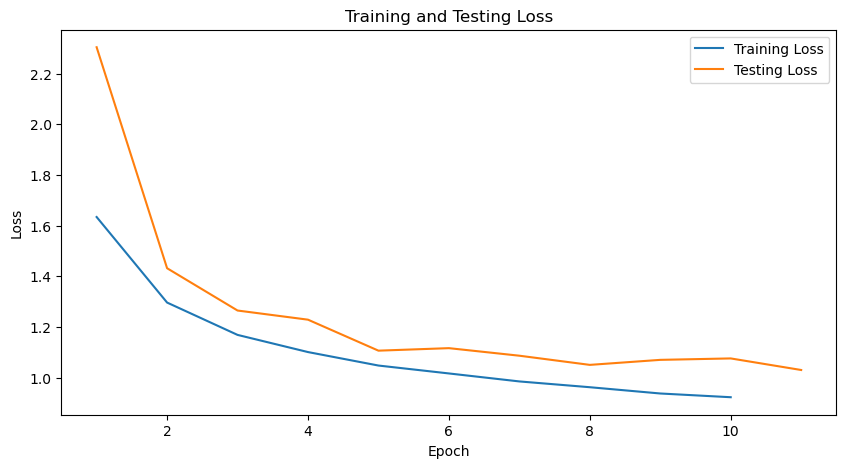

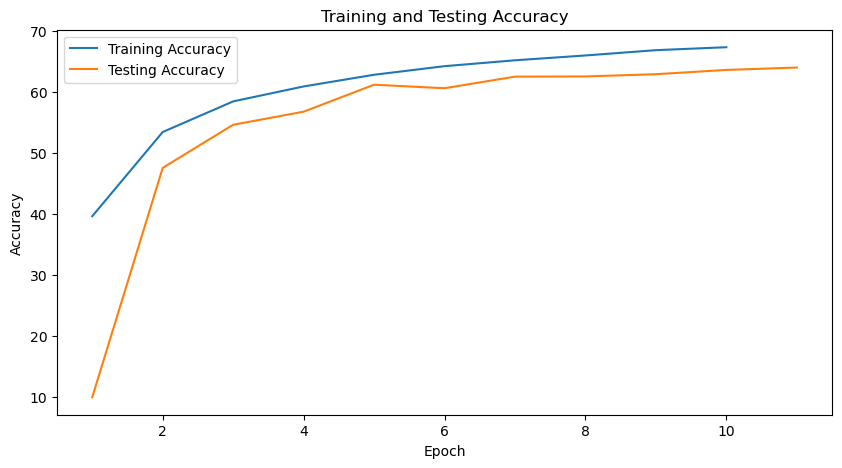

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [37]:
print(f"The best test accuracy : {torch.max(torch.from_numpy(test_accuracies))}")

The best test accuracy : 63.99
